### Обнаружение DNS туннелей в трафике

Предлагаемый подход: на основе n-грамм для анализа имен dns запросов

**Идея:** распределение частот встречаемости n-грамм в именах dns запросов (сейчас для простоты, но далее можно использовать энтропию и взаимную информацию) существенно отличается от "нормального" распределения частот. В качестве нормального в первом приближении можно использовать статистические соображения из естественного языка.

Другие подходы:
* статистические признаки запросов и ответов (в том числе размеры пакетов, время между сессиями)
* может на географическую локацию самих серверов можно смотреть

#### получим имена dns запросов

In [2]:
file_name ="../data/257_dump_sorted.pcap"
dns_temp_data = !tshark -r $file_name -T fields -e dns.qry.name -Y "dns.flags.response eq 0"

In [3]:
df = pd.DataFrame(dns_temp_data,columns=['dns_query'])
print(df.shape,df.drop_duplicates('dns_query').shape)
df.head()

(529, 1) (528, 1)


,dns_query
0,aaaa.g.6482.a.tun.reqw.xyz
1,aaaa.g.6747.a.tun.reqw.xyz
2,aaaa.g.7013.a.tun.reqw.xyz
3,aaaa.g.7247.a.tun.reqw.xyz
4,aaaa.g.576.a.tun.reqw.xyz


In [12]:
len(df[df.dns_query.str.contains('a.tun.reqw.xyz')])

529

In [25]:
df['dot_cnt'] = df.dns_query.str.count('\.')
df.dot_cnt.value_counts()

10    288
6     203
7      32
8       4
9       2
Name: dot_cnt, dtype: int64

In [21]:
df.iloc[9].values

array(['t.3evebjwzfjaknwjkictnsksau3msuqfg3evebjwzfjastwjkict5sksaqdmswq.fhxjctfq4giqs4dns6fhd22ty72k2vyh6dw5etfx5jlyu4tnzkictnsa2au7ms.q4e75ephdhxndzyzdyi4ocj6uhdrt3wb25m65ujhdf7adj2jp2azictnsksmu3.nsqz5g3evedjwzfneknxjineir4mzb5h52fyvim.0.6051.a.tun.reqw.xyz',
       252], dtype=object)

#### Построим гистограмму всего pcap'а

* признак - 1 символ английского алфавита

In [3]:
from sklearn.feature_extraction.text import CountVectorizer
from string import ascii_lowercase
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [4]:
vocabulary = ascii_lowercase
count_vec = CountVectorizer(lowercase=False,ngram_range=(1,1),analyzer='char',vocabulary=vocabulary)
X_char = count_vec.fit_transform(df.dns_query)
print(X_char.shape)

df_tdm = pd.DataFrame(data=X_char.toarray(),columns=count_vec.get_feature_names())
df_tdm.shape

(529, 26)


(529, 26)

#### Нормализуем

In [5]:
df_tdm = df_tdm/len(vocabulary)
df_tdm.head()

,a,b,c,d,e,f,g,h,i,j,...,q,r,s,t,u,v,w,x,y,z
0,0.192308,0.0,0.0,0.0,0.038462,0.0,0.038462,0.0,0.0,0.0,...,0.038462,0.038462,0.0,0.038462,0.038462,0.0,0.038462,0.038462,0.038462,0.038462
1,0.192308,0.0,0.0,0.0,0.038462,0.0,0.038462,0.0,0.0,0.0,...,0.038462,0.038462,0.0,0.038462,0.038462,0.0,0.038462,0.038462,0.038462,0.038462
2,0.192308,0.0,0.0,0.0,0.038462,0.0,0.038462,0.0,0.0,0.0,...,0.038462,0.038462,0.0,0.038462,0.038462,0.0,0.038462,0.038462,0.038462,0.038462
3,0.192308,0.0,0.0,0.0,0.038462,0.0,0.038462,0.0,0.0,0.0,...,0.038462,0.038462,0.0,0.038462,0.038462,0.0,0.038462,0.038462,0.038462,0.038462
4,0.192308,0.0,0.0,0.0,0.038462,0.0,0.038462,0.0,0.0,0.0,...,0.038462,0.038462,0.0,0.038462,0.038462,0.0,0.038462,0.038462,0.038462,0.038462


#### Согласно [авторам](http://norvig.com/mayzner.html) возьмем топовые буквы английского языка и построим распределение на наших данных.

#### Конечно, в дальнейшем неплохо бы иметь траффик с "нормальным" поведением, чтобы убедиться, что в нем будут такие же закономерности, что и на этих искусственных примерах

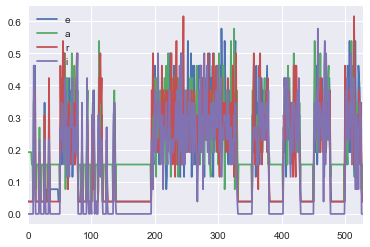

In [6]:
df_tdm[['e','a','r','i']].plot()

#### Теперь возьмем низкочастотные буквы английского языка и тоже построим распределение на наших даннных

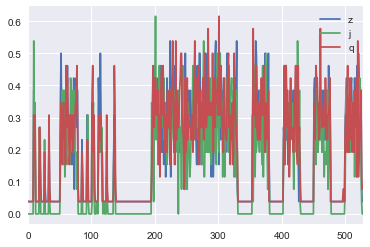

In [7]:
df_tdm[['z','j','q']].plot()

#### Распределения очень похожи, хотя не должны быть, значит можно пробовать использовать эти признаки для классификации

### Далее:
* нужно больше данных (с туннелями и без)
* достроить модель и попробовать биграммы, учитывать числа и т.д
* если не получится, попробовать другой подход